<a href="https://colab.research.google.com/github/SisekoC/My-Notebooks/blob/main/Object_Keypoint_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Keypoint Similarity in Keypoint Detection

In this notebook, we shall discuss about Object Keypoint Similarity (OKS) as a means to obtain the simialrity measure between two sets of keypoints. Furthermore, we shall also visualize a few results on the effect of object scale on OKS.

<img src = "https://learnopencv.com/wp-content/uploads/2023/08/object-keypoint-similarity-cases.png" width=1000>

We begin with our imports.

In [1]:
import os
import numpy as np
import cv2

import torch
import matplotlib.pyplot as plt

In [2]:
bold = f"\033[1m"
reset = f"\033[0m"

The function `draw_keypoints` is used to plot keypoints and edges given an image.

In [4]:
def draw_keypoints(image, keypoints, lm_color=(0,255,0), edge_color=(0,255,0)):

    image = image.copy()

    radius = 2
    # Check if image width is greater than 1000 px.
    # To improve visualization.
    if (image.shape[1] > 1000):
       radius = 8

    EDGES = [(0,1), (0,2), (1,3), (2,4), (3,5), (4,6), (5,7), (6,8),
             (7,9), (8,10), (5,11), (6,12), (11,13), (12,14), (13,15), (14,16)]

    for edge in EDGES:
        src_x, src_y   = keypoints[edge[0]].astype("int").tolist()
        dest_x, dest_y = keypoints[edge[1]].astype("int").tolist()
        cv2.line(image, (src_x, src_y), (dest_x, dest_y), color=edge_color, thickness=2, lineType=cv2.LINE_AA)

    for idx, coords in enumerate(keypoints):

        loc_x, loc_y = coords.astype("int").tolist()

        cv2.circle(image,
                   (loc_x, loc_y),
                   radius,
                   color=lm_color,
                   thickness=-1,
                   lineType=cv2.LINE_AA)


    return image

Recall that in object detection, **Intersection over Union (IoU)** forms an essential component for finding the similarity between two boxes and hence, computing the Mean Average Precision Precision (mAP). Its analogous to keypoint estimation is **Object Keypoint Similarity (OKS)**.

It is defined as:
$$OKS = \frac{\sum\limits_{i} \exp\left(\frac{-d_i^2}{2s^2k_i^2}\right)\delta(v_i>0)}{\sum\limits_{i} \delta(v_i>0)}$$

where:
* $d_i$ is the Euclidean distance between the ground-truth and predicted keypoint `i`
* $k$ is the per-keypoint constant
* $s$ is the scale of the ground truth object; $s^2$ hence becomes the object's segmented area.
* $v_i$ is the ground truth visibility flag for keypoint `i`
* $\delta(v_i>0)$ is the dirac-delta function which turns out to be `1` if the keypoint `i` is labeled, otherwise `0`

$k_i$ was tuned by measuring the per-keypoint standard deviation $\sigma_i$ with respect to the object scale. Finally, the setting: $k_i = 2 \sigma_i$ was used as the per-keypoint constant in COCO.

The per-keypoint standard deviation ($\sigma_i$) across all **17-COCO pose landmarks** is provided in the table below.

| Keypoint | SIGMA |
|:--------:|:--------:|
|  Nose   |   0.026   |
|  Eyes   |   0.025   |
|  Ears   |   0.035   |
|  Shoulders   |   0.079   |
|  Elbows   |   0.072   |
|  Wrists   |   0.062   |
|  Hips   |   0.107   |
|  Knees   |   0.087   |
|  Ankles   |   0.089   |

The function `keypoint_similarity` is used to compute the OKS between two sets of keypoints; primarily between the ground truths and the predictions. It takes in the following arguments:

* `gts_kpts`: Ground-truth keypoints having shape: `[M, #kpts, 3]`, where, `M` is the number of ground truth instances, and `3` in the last dimension denotes coordinates: x,y, and visibility flag.

* `pred_kpts`: Prediction keypoints having shape: `[N, #kpts, 3]` where, `N` is the number of predicted instances,

* `sigmas`: The per-keypoint standard deviations.

* `areas`: Represent ground truth areas of shape: `[M,]`

In [5]:
def keypoint_similarity(gt_kpts, pred_kpts, sigmas, areas):
    """
    Params:
        gts_kpts: Ground-truth keypoints, Shape: [M, #kpts, 3],
                  where, M is the # of ground truth instances,
                         3 in the last dimension denotes coordinates: x,y, and visibility flag

        pred_kpts: Prediction keypoints, Shape: [N, #kpts, 3]
                   where  N is the # of predicted instances,

        areas: Represent ground truth areas of shape: [M,]

    Returns:
        oks: The Object Keypoint Similarity (OKS) score tensor of shape: [M, N]
    """

    # epsilon to take care of div by 0 exception.
    EPSILON = torch.finfo(torch.float32).eps

    # Eucleidian dist squared:
    # d^2 = (x1 - x2)^2 + (y1 - y2)^2
    # Shape: (M, N, #kpts) --> [M, N, 17]
    dist_sq = (gt_kpts[:,None,:,0] - pred_kpts[...,0])**2 + (gt_kpts[:,None,:,1] - pred_kpts[...,1])**2

    # Boolean ground-truth visibility mask for v_i > 0. Shape: [M, #kpts] --> [M, 17]
    vis_mask = gt_kpts[..., 2].int() > 0

    # COCO assigns k = 2σ.
    k = 2*sigmas

    # Denominator in the exponent term. Shape: [M, 1, #kpts] --> [M, 1, 17]
    denom = 2 * (k**2) * (areas[:,None, None] + EPSILON)

    # Exponent term. Shape: [M, N, #kpts] --> [M, N, 17]
    exp_term = dist_sq / denom

    # Object Keypoint Similarity. Shape: (M, N)
    oks = (torch.exp(-exp_term) * vis_mask[:, None, :]).sum(-1) / (vis_mask[:, None, :].sum(-1) + EPSILON)

    return oks

Let us specify the path to the sample image directory.

In [7]:
#IMG_DIR = "/content/test_image_1.jpg"

Let us initialize the ground truth keypoints.

In [8]:
gt_kpts_1 = torch.tensor([[292, 93,  2],
                          [303, 84,  2],
                          [283, 84,  2],
                          [316, 92,  2],
                          [274, 90,  2],
                          [333, 129, 2],
                          [253, 128, 2],
                          [355, 181, 2],
                          [223, 180, 2],
                          [380, 227, 2],
                          [191, 215, 2],
                          [318, 251, 1],
                          [264, 250, 2],
                          [353, 307, 2],
                          [248, 300, 2],
                          [350, 387, 1],
                          [237, 388, 2]], dtype = torch.float)

We produce the sample detections by translating the ground truths to X, Y = `[-10, 7]` pixels. Hence the effective distance between them is $\sqrt{10^2 + 7^2}$ = 12.20 pixels.

In [9]:
det_kpts_1 = gt_kpts_1.clone()
det_kpts_1[:, :2]+= torch.tensor([-10, 7])

Next, we visualize the ground truth and the detected keypoints generated above.

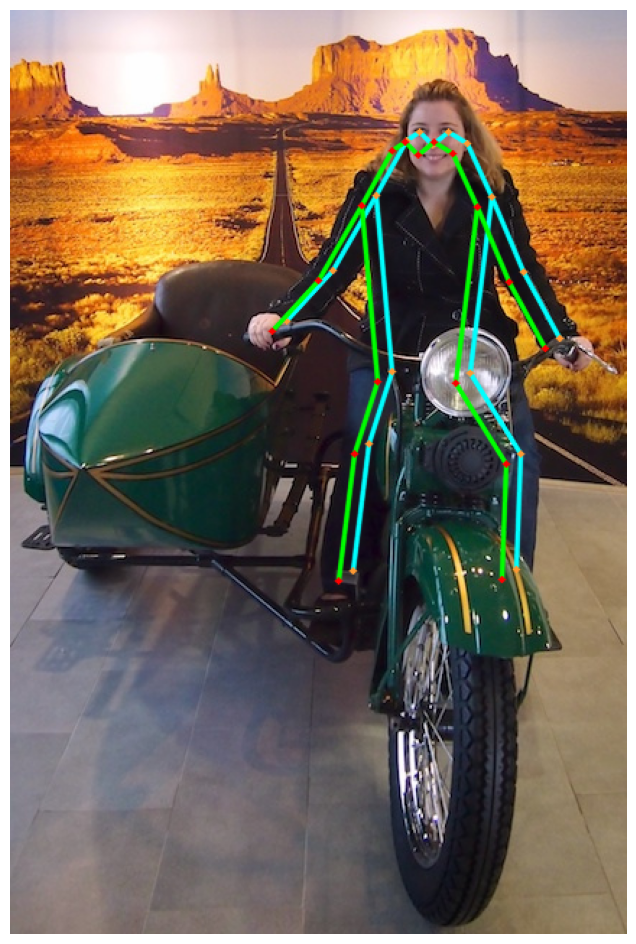

In [11]:
image = cv2.imread(os.path.join("test_image_1.jpg"))
img_kpts = draw_keypoints(image, gt_kpts_1[:,:2].numpy(), lm_color=(51,153,255), edge_color=(255,255,0))

img_det_kpts = draw_keypoints(img_kpts, det_kpts_1[:,:2].numpy(), lm_color=(0,0,255), edge_color=(0,255,0))
fig, ax = plt.subplots(figsize=(10, 12))
ax.imshow(img_det_kpts[...,::-1])
ax.axis("off")
plt.show()

The keypoints with `cyan` edges are the ground truths, while the ones with `green` edges are the detections.

### 1 Per-Keypoint Sigmas Initialized from COCO

Let us initialize the sigmas in accordance with COCO mentioned earlier.

**Note:** As mentioned earlier, area (or, $s^2$) is the object's segmented area, and not the bounding box area. In case, where only the bounding box data such as the **width** and **height** is available, the segmented area can be approximated by heuristically multiplying a scaling factor `0.53` with the bounding box area.

In [12]:
NUM_KPTs = 17

In [13]:
KPTS_OKS_SIGMAS_COCO = torch.tensor([.26, .25, .25, .35, .35, .79, .79, .72, .72, .62,.62, 1.07, 1.07, .87, .87, .89, .89])/10.0

In [14]:
areas = torch.tensor([30699.56495])
# areas = torch.tensor([237.43*359.78*0.53]) # Bounding box area.

oks_coco = keypoint_similarity(gt_kpts_1.unsqueeze(0),
                               det_kpts_1.unsqueeze(0),
                               sigmas=KPTS_OKS_SIGMAS_COCO,
                               areas=areas)

print(f"Object Keypoint Similarity (OKS) {bold}using COCO Sigmas{reset}: {round(float(oks_coco.squeeze()), 4)}")

Object Keypoint Similarity (OKS) using COCO Sigmas: 0.7812


### 2 Per-Keypoint Sigmas Sampled from Uniform Distribution

In [15]:
KPTS_OKS_SIGMAS_UNIF = torch.ones(NUM_KPTs)/NUM_KPTs

In [16]:
oks_unf_sigma = keypoint_similarity(gt_kpts_1.unsqueeze(0),
                                    det_kpts_1.unsqueeze(0),
                                    sigmas=KPTS_OKS_SIGMAS_UNIF,
                                    areas=areas)

print(f"Object Keypoint Similarity (OKS) {bold}using Uniform Sigmas{reset}: {round(float(oks_unf_sigma.squeeze()), 4)}")

Object Keypoint Similarity (OKS) using Uniform Sigmas: 0.8392


### 3 Effect of Euclidean Distance on OKS for Large Objects

Let us now compute the OKS score by translating the ground truth keypoints to X, Y = `[12.5, 5]`.

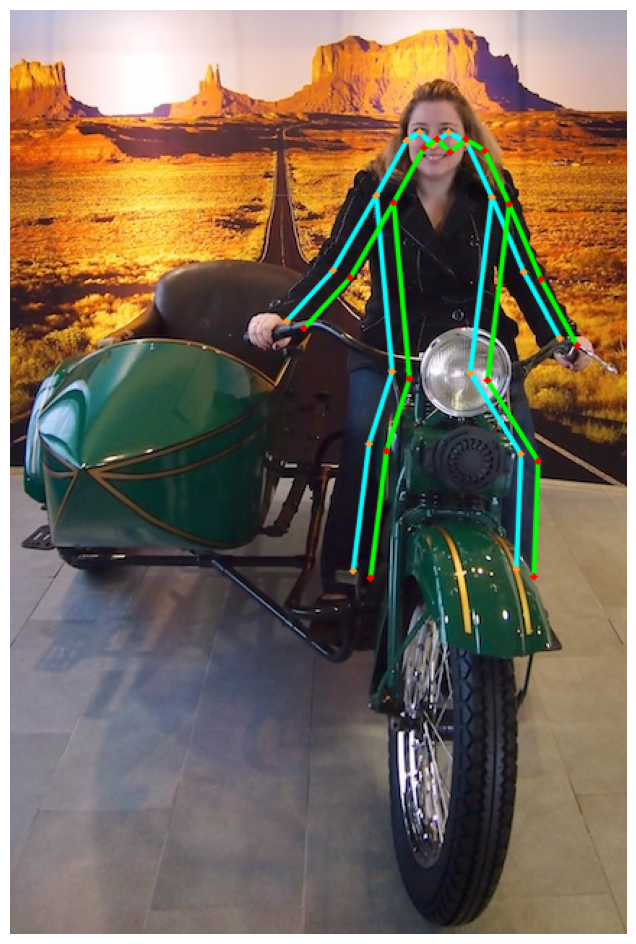

In [17]:
det_kpts_2 = gt_kpts_1.clone()
det_kpts_2[:, :2]+= torch.tensor([12.5, 5])

img_det_kpts_2 = draw_keypoints(img_kpts, det_kpts_2[:,:2].numpy(), lm_color=(0,0,255), edge_color=(0,255,0))
fig, ax = plt.subplots(figsize=(10, 12))
ax.imshow(img_det_kpts_2[...,::-1])
ax.axis("off")
plt.show()

In [18]:
oks_coco = keypoint_similarity(gt_kpts_1.unsqueeze(0),
                               det_kpts_2.unsqueeze(0),
                               sigmas=KPTS_OKS_SIGMAS_COCO, areas=areas)

print(f"Object Keypoint Similarity (OKS) {bold}using COCO Sigmas{reset}: {round(float(oks_coco.squeeze()), 4)}")

Object Keypoint Similarity (OKS) using COCO Sigmas: 0.7481


In [19]:
oks_unf_sigma = keypoint_similarity(gt_kpts_1.unsqueeze(0),
                                    det_kpts_2.unsqueeze(0),
                                    sigmas=KPTS_OKS_SIGMAS_UNIF,
                                    areas=areas)

print(f"Object Keypoint Similarity (OKS) {bold}using Uniform Sigmas{reset}: {round(float(oks_unf_sigma.squeeze()), 4)}")

Object Keypoint Similarity (OKS) using Uniform Sigmas: 0.8079


From the OKS values above, one can observe that the effective distance was increased from $\sqrt{10^2 + 7^2} = 12.207$ pixels to $\sqrt{12.5^2 + 5^2} = 13.463$ pixels. Although the OKS score has decreased, which was expected, this distance increase did not have a significant bearing on the OKS score. This is primarily attributed to the scale factor (the object area of which was `30699.56495` pixels), which is quite significant here.

In the next section, we shall explore how does the eucledian distance affect the OKS scores for small scaled objects.

### 4 Effect of Euclidean distance on OKS for Small Objects

Let us now take an example of a small object instance.

In [20]:
gt_kpts_2 = torch.tensor([[254, 294, 2],
                          [255, 292, 2],
                          [253, 292, 2],
                          [256, 294, 2],
                          [249, 293, 2],
                          [261, 304, 2],
                          [242, 304, 1],
                          [264, 319, 2],
                          [239, 317, 1],
                          [258, 328, 2],
                          [242, 329, 2],
                          [258, 330, 2],
                          [248, 331, 2],
                          [263, 348, 2],
                          [246, 352, 2],
                          [255, 371, 2],
                          [247, 373, 2]
                        ], dtype = torch.float)

Let us visualize the ground truth keypoints.

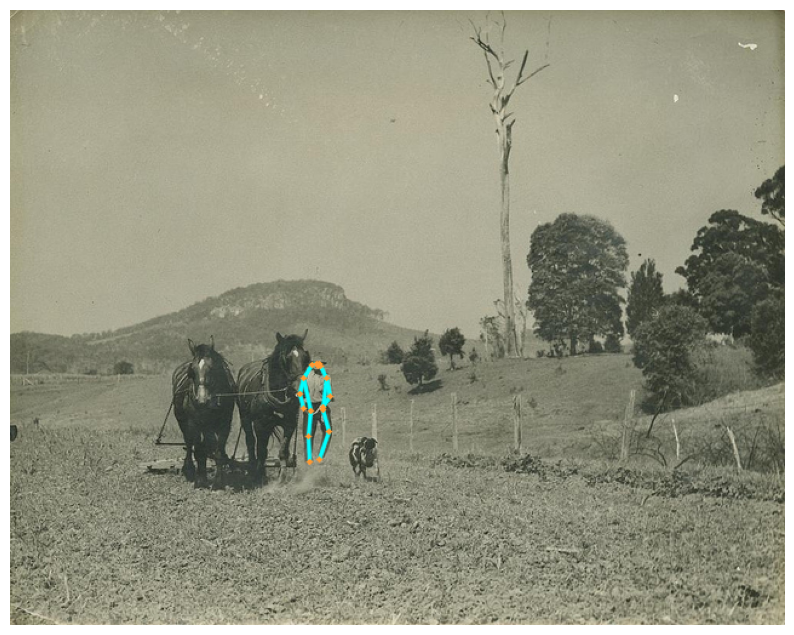

In [21]:
image_2 = cv2.imread(os.path.join("test_image_2.jpg"))
img_kpts_2 = draw_keypoints(image_2, gt_kpts_2[:,:2].numpy(), lm_color=(51,153,255), edge_color=(255,255,0))
fig, ax = plt.subplots(figsize=(10, 12))
ax.imshow(img_kpts_2[...,::-1])
ax.axis("off")
plt.show()

Let us now synthetically generate the detections by translating the ground truth keypoints to [5, 3], such that the effective distance between them becomes $\sqrt{5^2 + 3^2}$ = 5.83 pixels.

In [22]:
det_kpts_3 = gt_kpts_2.clone()
det_kpts_3[:, :2]+= torch.tensor([5, 3])

Let us see how the visualization looks. The ground truth is represented with `cyan` edges, while that of the predictions represent `green` edges.

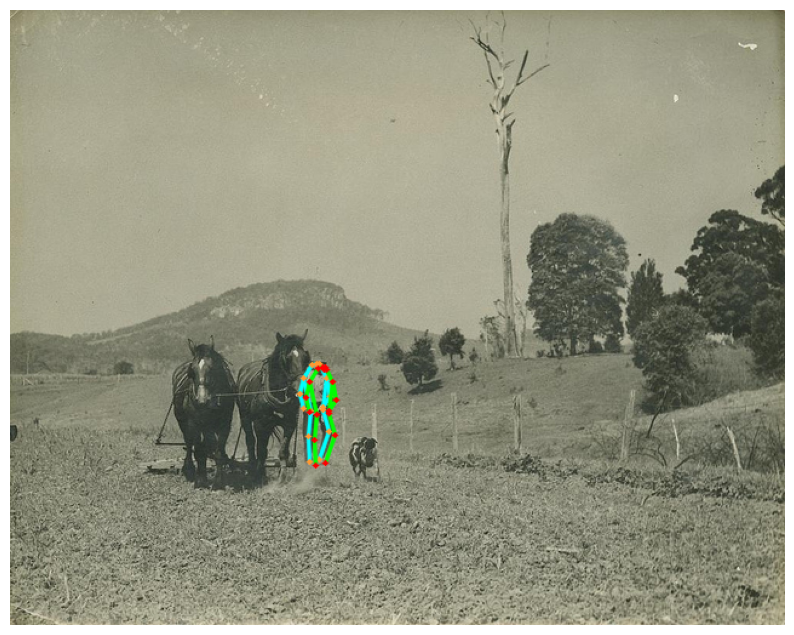

In [23]:
img_det_kpts_3 = draw_keypoints(img_kpts_2, det_kpts_3[:,:2].numpy(), lm_color=(0,0,255), edge_color=(0,255,0))
fig, ax = plt.subplots(figsize=(10, 12))
ax.imshow(img_det_kpts_3[...,::-1])
ax.axis("off")
plt.show()

Next, we shall compute the OKS score between the ground truth and predicted keypoints.

In [24]:
areas_small = torch.tensor([1576.46005])
# area_bbox = torch.tensor([26.74*91.98])
oks_small_coco = keypoint_similarity(gt_kpts_2.unsqueeze(0),
                                     det_kpts_3.unsqueeze(0),
                                     sigmas=KPTS_OKS_SIGMAS_COCO,
                                     areas=areas_small)

print(f"Object Keypoint Similarity (OKS) {bold}using COCO Sigmas{reset}: {round(float(oks_small_coco.squeeze()), 4)}")

Object Keypoint Similarity (OKS) using COCO Sigmas: 0.4794


In [25]:
oks_small_unif = keypoint_similarity(gt_kpts_2.unsqueeze(0),
                                     det_kpts_3.unsqueeze(0),
                                     sigmas=KPTS_OKS_SIGMAS_UNIF,
                                     areas=areas_small)

print(f"Object Keypoint Similarity (OKS) {bold}using Uniform Sigmas{reset}: {round(float(oks_small_unif.squeeze()), 4)}")

Object Keypoint Similarity (OKS) using Uniform Sigmas: 0.4588


Finally, we shall now translate the ground truth boxes to `X, Y = [6, 3.77]` pixels and use them as our detections.

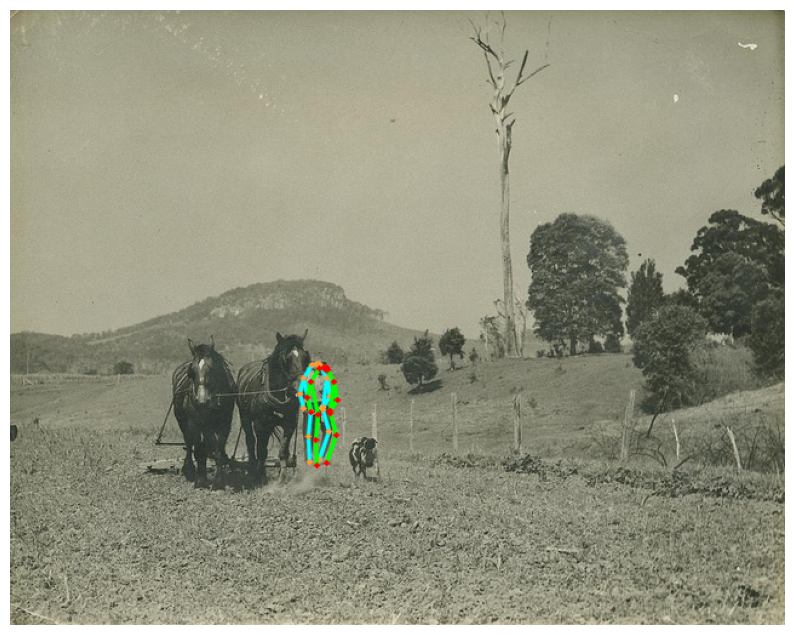

In [26]:
det_kpts_4 = gt_kpts_2.clone()
det_kpts_4[:, :2]+= torch.tensor([6, 3.77])

img_det_kpts_4 = draw_keypoints(img_kpts_2, det_kpts_4[:,:2].numpy(), lm_color=(0,0,255), edge_color=(0,255,0))
fig, ax = plt.subplots(figsize=(10, 12))
ax.imshow(img_det_kpts_4[...,::-1])
ax.axis("off")
plt.show()

In [27]:
oks_small_coco = keypoint_similarity(gt_kpts_2.unsqueeze(0),
                                     det_kpts_4.unsqueeze(0),
                                     sigmas=KPTS_OKS_SIGMAS_COCO,
                                     areas=areas_small)
print(f"Object Keypoint Similarity (OKS) {bold}using COCO Sigmas{reset}: {round(float(oks_small_coco.squeeze()), 4)}")

Object Keypoint Similarity (OKS) using COCO Sigmas: 0.3872


We can see that although the effective distance changes from $\sqrt{5^2 + 3^2} = 5.831$ pixels to $\sqrt{6^2 + 3.77^2} = 7.086$ pixels, the OKS score reduces significantly!

The object's diminutive scale is the key reason behind this.

Let us see the OKS score with the per-keypoint standard deviations sampled from the uniform distribution used earlier.

In [28]:
oks_small_unif = keypoint_similarity(gt_kpts_2.unsqueeze(0),
                                     det_kpts_4.unsqueeze(0),
                                     sigmas=KPTS_OKS_SIGMAS_UNIF,
                                     areas=areas_small)
print(f"Object Keypoint Similarity (OKS) {bold}using Uniform Sigmas{reset}: {round(float(oks_small_unif.squeeze()), 4)}")

Object Keypoint Similarity (OKS) using Uniform Sigmas: 0.3164
